## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import sklearn

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from pathlib import Path
from IPython.display import Image, display, Video, HTML
from ipywidgets import interact, widgets

from signlens.params import *
from signlens.preprocessing import data, preprocess
from utils import plot_landmarks, model_utils

# reload automatically python functions outside notebook
%load_ext autoreload
%autoreload 2

2024-03-22 13:35:33.345830: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-22 13:35:37.298209: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Fetch data

In [2]:
# variables loaded from .env
print(f"DATA_FRAC : {DATA_FRAC}")
print(f"NUM_CLASSES : {NUM_CLASSES}")
print(f"MAX_SEQ_LEN : {MAX_SEQ_LEN}")

DATA_FRAC : 1.0
NUM_CLASSES : 10
MAX_SEQ_LEN : 100


In [3]:
sequences_data = data.load_data_subset_csv(noface=True, balanced=True, n_classes=NUM_CLASSES)

Loading data subset from train_train.csv
✅ Filtered on n_frames = 100. Size reduced from 94461 to 85660 (90.7%)
✅ Filtered on n_classes = 10. Size reduced from 85660 to 3469 (4.0%)
⚠️ Total size smaller than requested, with 330 per sign instead of 346
✅ Balanced data, with average of 330.0 elements per class. Size reduced from 3469 to 3300 (95.1%)
✅ Loaded 3469 rows (3.5% of the original 94461 rows) from the dataset.


In [4]:
sequences_data.sign.value_counts()

sign
yes       330
before    330
chair     330
book      330
who       330
no        330
fine      330
go        330
drink     330
all       330
Name: count, dtype: int64

In [26]:
from sklearn.model_selection import train_test_split

X_files = sequences_data.file_path
y = preprocess.label_dictionnary(sequences_data)

# Train val split
X_train_files, X_val_files, y_train, y_val = train_test_split(X_files, y, test_size=0.2, stratify=y)


In [33]:
X_train = preprocess.group_pad_sequences_sparse(X_train_files)
X_val = preprocess.group_pad_sequences_sparse(X_val_files)


In [36]:
X_train

SparseTensor(indices=tf.Tensor(
[[   0    0   63]
 [   0    0   64]
 [   0    0   65]
 ...
 [2639    5  159]
 [2639    5  160]
 [2639    5  161]], shape=(9427041, 3), dtype=int64), values=tf.Tensor(
[ 0.51208615  0.3900284  -0.91650015 ...  0.27475965  2.3570588
 -0.120417  ], shape=(9427041,), dtype=float32), dense_shape=tf.Tensor([2640  100  225], shape=(3,), dtype=int64))

In [55]:
sparse_tensor = X_train
# Count the number of non-zero values
import tensorflow as tf

# Assume `sparse_tensor` is your SparseTensor

# Create a boolean tensor where True indicates a non-zero value
non_zero_mask = tf.sparse.to_dense(sparse_tensor) != 0

# Cast the boolean tensor to a float tensor
non_zero_mask_float = tf.cast(non_zero_mask, tf.float32)

# Count the number of non-zero values
non_zero_count = tf.reduce_sum(non_zero_mask_float)

print(f"Number of non-zero values: {non_zero_count.numpy()}")

# Calculate the total number of elements in the tensor
total_count = tf.reduce_prod(sparse_tensor.dense_shape).numpy()

# Calculate the percentage of non-zero values
percentage = (non_zero_count / total_count) * 100

print(f"Percentage of non-zero values: {percentage.numpy()}%")

Number of non-zero values: 9427041.0
Percentage of non-zero values: 15.870439529418945%


## Model

In [66]:
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import TimeDistributed, LSTM, Dense, Masking, Flatten, Dropout, SimpleRNN, Reshape, Bidirectional, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

TensorShape([100, 225])

In [77]:
# 1- RNN Architecture
model = Sequential()

model.add(Input(shape=(X_train.shape[1:]), sparse=True, name='name_sparse'))



# model.add(Reshape((MAX_SEQ_LEN, N_LANDMARKS_NO_FACE * 3),
#           input_shape=(MAX_SEQ_LEN, N_LANDMARKS_NO_FACE, 3)))
# model.add(Masking(mask_value=0.0))

model.add(SimpleRNN(units=128, return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(units=64))
model.add(Dropout(0.5))

model.add(Dense(NUM_CLASSES, activation='softmax'))  # output layer



model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_14 (SimpleRNN)       │ (None, 100, 128)       │        45,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95,370 (372.54 KB)

 Trainable params: 95,370 (372.54 KB)

 Non-trainable params: 0 (0.00 B)

In [87]:
from tensorflow.keras.layers import Input, Dense, Dropout, SimpleRNN, LSTM
from tensorflow.keras.models import Model

# Define the input layer
inputs = Input(shape=X_train.shape[1:], sparse=True)  # Assuming X_train is already converted to a dense representation

# Define the layers
x = Dense(128)(inputs)  # You may use other methods like embedding layers for sparse data
x = SimpleRNN(units=128, return_sequences=True)(x)
x = Dropout(0.5)(x)
x = LSTM(units=64)(x)
x = Dropout(0.5)(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)  # output layer

# Define the model
model = Model(inputs=inputs, outputs=outputs)

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.summary()


Model: "functional_84"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 100, 225)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 100, 128)       │        28,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_18 (SimpleRNN)       │ (None, 100, 128)       │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,882 (437.04 KB)

 Trainable params: 111,882 (437.04 KB)

 Non-trainable params: 0 (0.00 B)

In [88]:
# Fit model

es = EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=100,
                    batch_size=32, 
                    verbose=1, 
                    callbacks = [es] # This will call the Early Stopping Criterion for each epoch
                   )


ValueError: Unrecognized data type: x=SparseTensor(indices=tf.Tensor(
[[   0    0   63]
 [   0    0   64]
 [   0    0   65]
 ...
 [2639    5  159]
 [2639    5  160]
 [2639    5  161]], shape=(9427041, 3), dtype=int64), values=tf.Tensor(
[ 0.51208615  0.3900284  -0.91650015 ...  0.27475965  2.3570588
 -0.120417  ], shape=(9427041,), dtype=float32), dense_shape=tf.Tensor([2640  100  225], shape=(3,), dtype=int64)) (of type <class 'tensorflow.python.framework.sparse_tensor.SparseTensor'>)

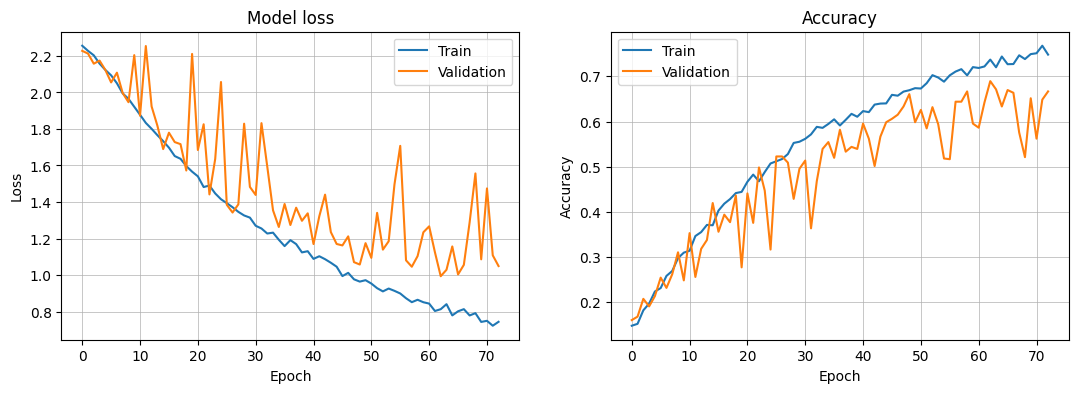

In [12]:
model_utils.plot_history(history)